# Exercise sheet 10

## NWO grant applications

### Exercise 1

For this exercise, you will need to load the dataset NWOGrants from the rethinking package. This dataset reports on the funding outcomes of the Netherlands Organisation for Scientific Research (NWO) grant applications over the 2010-2012 period. One study used that dataset to investigate gender bias in the funding awards: https://www.pnas.org/content/112/40/12349. You can read there that a response to this paper has been formulated, as briefly discussed at the beginning of lecture 9. Note that in general less than half applications are awarded funding.

Address the same question as the one in the paper by Lee and Ellemers by using binomial GLM to investigate potential gender bias on awards. Quantify the contrast between male and female applicants. In a second step, condition on the discipline as well. What are your conclusions? Should the NWO take specific measures for gender equity in general and across disciplines? Is there any excess variance in the data? If yes, can you elaborate on the nature of possible unaccounted sources?

In [24]:
library(rethinking)
data(NWOGrants)
d <- NWOGrants

In [77]:
d$male <- as.integer(d$gender) - 1
d$field <- as.integer(d$discipline)
d$accept <- d$awards / d$applications
d <- d[order(d$field), ]
d

,discipline,gender,applications,awards,male,field,accept
,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>
1,Chemical sciences,m,83,22,1,1,0.2650602
2,Chemical sciences,f,39,10,0,1,0.2564103
13,Earth/life sciences,m,156,38,1,2,0.2435897
14,Earth/life sciences,f,126,18,0,2,0.1428571
7,Humanities,m,230,33,1,3,0.1434783
8,Humanities,f,166,32,0,3,0.1927711
11,Interdisciplinary,m,105,12,1,4,0.1142857
12,Interdisciplinary,f,78,17,0,4,0.2179487
17,Medical sciences,m,245,46,1,5,0.1877551


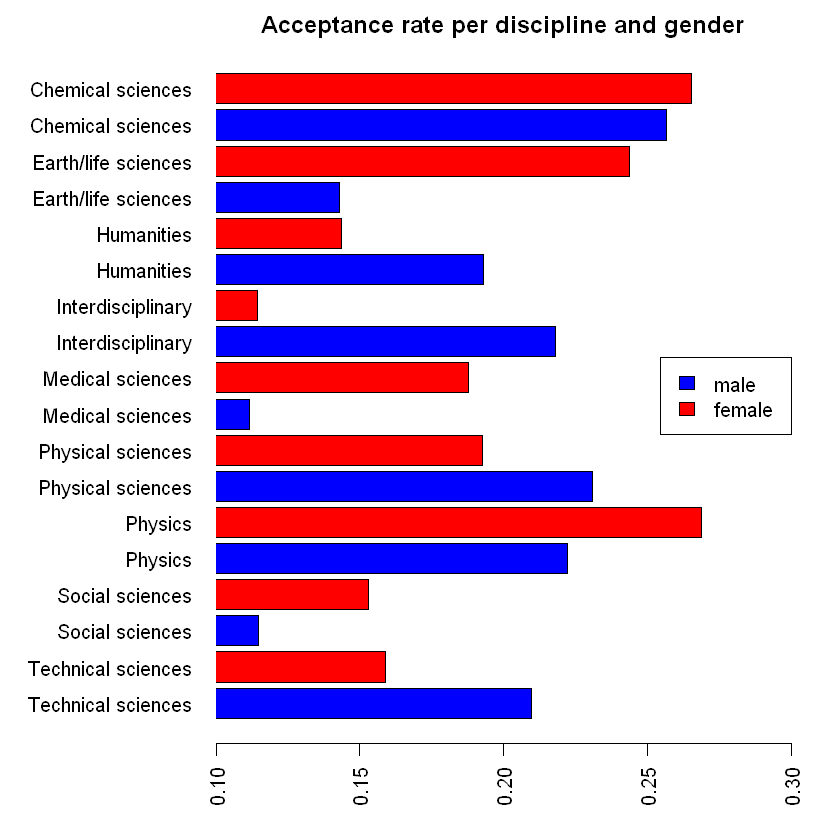

In [87]:
par(mar = c(4, 9, 2, 2))
barplot(rev(d$accept), names.arg = rev(d$discipline), las=2, xlim = c(0.10, 0.30), xpd = FALSE, horiz = TRUE, col = ifelse(d$male, "blue", "red"))
title("Acceptance rate per discipline and gender")
legend("right", c("male", "female"), fill = c("blue", "red"))

In [34]:
e <- data.frame(discipline = character(), applications = integer(), awards = integer(), field = integer(), accept = double())
for (field in 1:max(d$field)) {
	dat <- d[d$field == field, ]
	discipline <- as.character(dat$discipline[1])
	applications <- sum(dat$applications)
	awards <- sum(dat$awards)
	accept <- awards / applications
	e[nrow(e) + 1, ] <- list(discipline, applications, awards, field, accept)
}
e

,discipline,applications,awards,field,accept
,<chr>,<int>,<int>,<int>,<dbl>
1,Chemical sciences,122,32,1,0.2622951
2,Earth/life sciences,282,56,2,0.1985816
3,Humanities,396,65,3,0.1641414
4,Interdisciplinary,183,29,4,0.1584699
5,Medical sciences,505,75,5,0.1485149
6,Physical sciences,174,35,6,0.2011494
7,Physics,76,20,7,0.2631579
8,Social sciences,834,112,8,0.1342926
9,Technical sciences,251,43,9,0.1713147


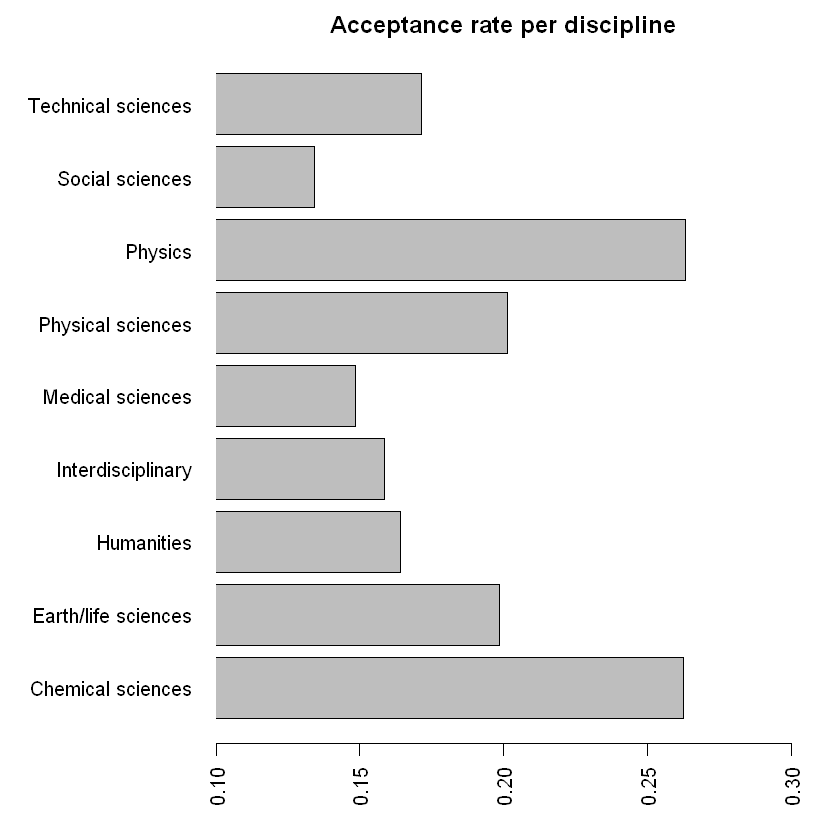

In [72]:
par(mar = c(4, 9, 2, 2))
barplot(e$accept, names.arg = e$discipline, las=2, xlim = c(0.10, 0.30), xpd = FALSE, horiz = TRUE)
title("Acceptance rate per discipline")